In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from pipeline_transformers import LogTransformer, FeatureCreation, FeatureRemoval

C:\Users\nbeha\AppData\Local\Temp\ipykernel_10888\834334365.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def calculate_ks(df, target, preds1, preds0, identifier=''):

    df0 = df[df[target] == 0]
    df1 = df[df[target] == 1]

    ks = ks_2samp(df0[preds0], df1[preds1])
    print(f"{identifier} KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
valid = pd.read_csv('valid.csv')


keys = ['fake_cnpj', 'date_reference']
target = 'TARGET_default_within_11m'
features = [
    'chk_esp_cred_rot_a_vencer_pct_risco',
    'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo',
    'cnt_declined_reasons',
    'days_since_oldest_board_member',
    'general_a_vencer_pct_risco',
    'general_a_vencer_weighted_periodo_div_pct_risco',
    'general_limite_de_cred_sum_pct_risco',
    'general_limite_trend_6mo',
    'general_lost_pct_cart_cred',
    'general_lost_pct_risco',
    'general_vencido_max_prev_6mo',
    'general_vencido_pct_carteira_cred__max_prev_6mo',
    'general_vencido_pct_risco_max_prev_6mo',
    'general_vencido_sum_sum_pct_risco',
    'v204r_is_popular_domain',
    'v254r_cnt_board_memebers',
    'years_since_first_relationship',
    'general_limite_de_cred_sum',
    'general_lost_sum',
    'general_vencido_sum'
    ]

model_pipeline = pickle.load(open('artifacts/model.pkl', 'rb'))

In [4]:
# preds1 stands for the probability of default, preds0 stands for the probability of non-default
train_preds = model_pipeline.predict_proba(train[features])
test_preds = model_pipeline.predict_proba(test[features])
valid_preds = model_pipeline.predict_proba(valid[features])

train['preds1'] = train_preds[:, 1]
train['preds0'] = train_preds[:, 0]
test['preds1'] = test_preds[:, 1]
test['preds0'] = test_preds[:, 0]
valid['preds1'] = valid_preds[:, 1]
valid['preds0'] = valid_preds[:, 0]

c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["general_lost_sum__over__general_limite_de_cred_sum"] = (
c:\Users\nbeh

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["general_lost_sum__over__general_limite_de_cred_sum"] = (
c:\Users\nbeh

In [5]:
calculate_ks(train, 'TARGET_default_within_11m', 'preds1', 'preds0', 'train')
calculate_ks(test, 'TARGET_default_within_11m', 'preds1', 'preds0', 'test')
calculate_ks(valid, 'TARGET_default_within_11m', 'preds1', 'preds0', 'valid')

np.random.seed(1)
random_default = np.random.rand(train.shape[0])
random_df = pd.DataFrame({
    'preds1': random_default,
    'preds0': 1 - random_default,
    'TARGET_default_within_11m': np.random.choice([0, 1], len(random_default), p=[train['TARGET_default_within_11m'].mean(), 1-train['TARGET_default_within_11m'].mean()])
})

calculate_ks(random_df, 'TARGET_default_within_11m', 'preds1', 'preds0', 'random')


train KS: 0.7744 (p-value: 1.285e-321)
test KS: 0.8754 (p-value: 0.000e+00)
valid KS: 0.8633 (p-value: 0.000e+00)
random KS: 0.0218 (p-value: 8.894e-01)


In [6]:
def assign_decile(x, bins):
    for bin_ in bins:
        if bin_['min'] <= x <= bin_['max']:
            return bin_['decile']
    return 0


# constructing bins for the scorecard
train['decile'] = pd.qcut(train['preds1'], 10, labels=False)
train_binned = train.groupby('decile').agg({target: ['mean', 'sum'], 'preds1': ['min', 'max']}).reset_index()
train_binned.columns = ['decile', 'mean', 'defaults', 'min', 'max']

bins = train_binned[['decile', 'min', 'max']]
bins['max'] = (bins['min'] - 1e-6).shift(-1).fillna(1)
bins = bins.to_dict(orient='records')

def attribute_default_statistics(df, target, preds1_col, bins, identifier=''):
    df['decile'] = df['preds1'].apply(lambda x: assign_decile(x, bins))
    binned = df.groupby('decile').agg({target: ['mean', 'sum', 'count'], preds1_col: ['min', 'max']}).reset_index()
    binned.columns = ['decile', 'mean', 'defaults', 'customers', 'min', 'max']
    binned['data'] = identifier
    return binned

train_binned = attribute_default_statistics(train, target, 'preds1', bins, 'train')
test_binned = attribute_default_statistics(test, target, 'preds1', bins, 'test')
valid_binned = attribute_default_statistics(valid, target, 'preds1', bins, 'valid')

C:\Users\nbeha\AppData\Local\Temp\ipykernel_10888\1950066647.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bins['max'] = (bins['min'] - 1e-6).shift(-1).fillna(1)


In [7]:
bins_df = pd.DataFrame(bins)
bins_df

,decile,min,max
0,0,0.000000,0.005269
1,1,0.005270,0.020153
2,2,0.020154,0.030938
3,3,0.030939,0.051108
4,4,0.051109,0.078957
5,5,0.078958,0.121489
6,6,0.121490,0.172062
7,7,0.172063,0.260102
8,8,0.260103,0.411327
9,9,0.411328,1.000000


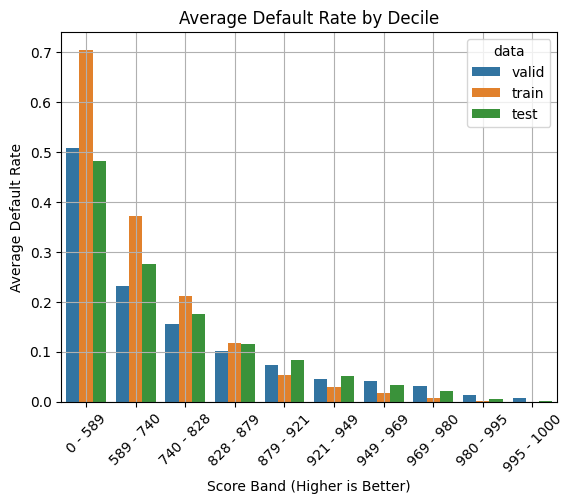

In [8]:
bins_average_default_rate = pd.concat([train_binned, test_binned, valid_binned])
plot_data = bins_average_default_rate.sort_values('decile', ascending=False)
plot_data['rev_decile'] = plot_data['decile'].apply(lambda x: 9 - x)

scores = [f"{1000*(1-j):.0f} - {1000*(1-i):.0f}" for (i, j) in zip(bins_df['min'], bins_df['max'])]
sns.barplot(x='rev_decile', y='mean', data=plot_data, hue='data')
plt.xticks(rotation=45, labels=scores[::-1], ticks=list(range(10)))
plt.title('Average Default Rate by Decile')
plt.xlabel('Score Band (Higher is Better)')
plt.ylabel('Average Default Rate')
plt.grid()
plt.show()


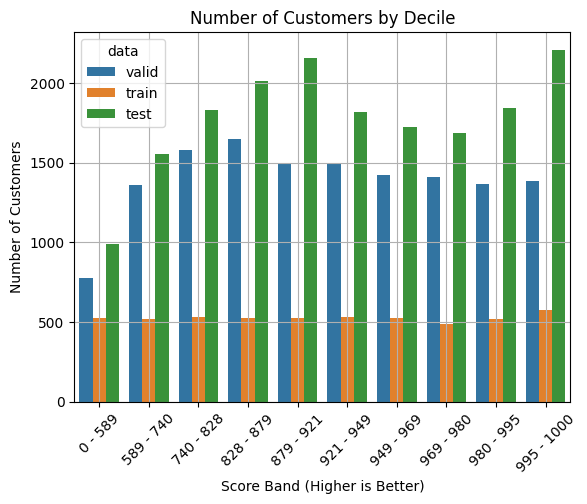

In [9]:
bins_average_default_rate = pd.concat([train_binned, test_binned, valid_binned])
plot_data = bins_average_default_rate.sort_values('decile', ascending=False)
plot_data['rev_decile'] = plot_data['decile'].apply(lambda x: 9 - x)

scores = [f"{1000*(1-j):.0f} - {1000*(1-i):.0f}" for (i, j) in zip(bins_df['min'], bins_df['max'])]
sns.barplot(x='rev_decile', y='customers', data=plot_data, hue='data')
plt.xticks(rotation=45, labels=scores[::-1], ticks=list(range(10)))
plt.title('Number of Customers by Decile')
plt.xlabel('Score Band (Higher is Better)')
plt.ylabel('Number of Customers')
plt.grid()
plt.show()


In [11]:
bins_average_default_rate.sort_values(['data', 'decile'], ascending=False)

,decile,mean,defaults,customers,min,max,data
9,9,0.507752,393,774,0.411787,0.960000,valid
8,8,0.231959,315,1358,0.260748,0.411213,valid
7,7,0.155795,246,1579,0.172063,0.259923,valid
6,6,0.101757,168,1651,0.121527,0.172033,valid
5,5,0.072959,109,1494,0.079011,0.121425,valid
4,4,0.045546,68,1493,0.051109,0.078914,valid
3,3,0.040845,58,1420,0.030939,0.050994,valid
2,2,0.031892,45,1411,0.020154,0.030825,valid
1,1,0.012472,17,1363,0.005270,0.019833,valid
0,0,0.007937,11,1386,0.000000,0.005203,valid
